In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as lm
sns.set()

# Modeling COVID-19 Death Rate in the United States: Code

## Data Cleaning

In [3]:
# Reading in csv files and assigning them as dataframes
confirmed = pd.read_csv('./time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('./time_series_covid19_deaths_US.csv')
abridged_counties = pd.read_csv('./county_data_abridged.csv')

In [6]:
# Cleaning confirmed dataset

confirmed1 = confirmed.iloc[:, 11:124]
confirmed1['confirmed sum'] = confirmed1.sum(axis=1)
confirmed1["FIPS"] = confirmed["FIPS"]
confirmed1 = confirmed1.fillna(0)
confirmed1 = confirmed1.astype(int)
confirmed1 = confirmed1[['confirmed sum', 'FIPS']]
confirmed1

# Cleaning deaths dataset

deaths1 = deaths.iloc[:, 12:124]
deaths1['total deaths'] = deaths1.sum(axis=1)
deaths1["FIPS"] = deaths["FIPS"]
deaths1 = deaths1.fillna(0)
deaths1 = deaths1.astype(int)
deaths1 = deaths1[['total deaths', 'FIPS']]
deaths1

,total deaths,FIPS
0,0,60
1,209,66
2,78,69
3,2799,72
4,109,78
...,...,...
3256,0,0
3257,0,0
3258,50,0
3259,0,0


In [4]:
# Joining confirmed1 and deaths1 table and creating death rate column

confirmed_and_deaths = confirmed1.join(deaths1.set_index('FIPS'), on='FIPS')
confirmed_and_deaths.reindex(columns=['FIPS', 'confirmed sum', 'total deaths'])
confirmed_and_deaths['death rate'] = confirmed_and_deaths['total deaths']/confirmed_and_deaths['confirmed sum']
confirmed_and_deaths = confirmed_and_deaths.fillna(confirmed_and_deaths.median())
confirmed_and_deaths

# Changing abridged_counties so that it is joinable with confirmed_and_deaths table

abridged_counties = abridged_counties.rename(columns = {"countyFIPS" : "FIPS"})
cleansed_counties = abridged_counties.iloc[:3242, :]
cleansed_counties["FIPS"] = cleansed_counties["FIPS"].astype(int)

# Joining abridged_counties and confirmed_and_deaths table onto "FIPS" column

comp_table = cleansed_counties.join(confirmed_and_deaths.set_index('FIPS'), on='FIPS')
comp_table["death rate"] = comp_table["death rate"].fillna(comp_table["death rate"].median())

# Cleaning the dataset to only contain 

comp_table = comp_table[(comp_table["death rate"] > 0) & (comp_table["confirmed sum"] > 1000)]

# Choosing columns that have 50% or more non-null values
comp_table1 = comp_table.loc[:, comp_table.isnull().mean() < .6]

# Deleting columns that are not needed for analysis or are repetitive
comp_table2 = comp_table1.drop(columns=['STATEFP', 'State', 'POP_LATITUDE', 'POP_LONGITUDE', '#HospParticipatinginNetwork2017', '3-YrDiabetes2015-17'])

# Adding columns
comp_table2['elderly ratio'] = comp_table2.iloc[:, 53:63].sum(axis=1)/comp_table2['CensusPopulation2010']
comp_table2['ICU beds per population'] = comp_table2["#ICU_beds"]/comp_table2["PopulationEstimate2018"]
comp_table2["Medicare Percentage"] = comp_table2["MedicareEnrollment,AgedTot2017"]/comp_table2["PopulationEstimate2018"]

# Fill Null Values
comp_table2 = comp_table2.fillna(comp_table2.median())
comp_table2


/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,FIPS,COUNTYFP,CountyName,StateName,lat,lon,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,...,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,confirmed sum,total deaths,death rate,elderly ratio,ICU beds per population,Medicare Percentage
0,1001,1.0,Autauga,AL,32.540091,-86.645649,South,East South Central,2.0,55601.0,...,0.4354,3.82,12510.0,11414.0,1513.0,84.0,0.055519,0.051163,0.000108,0.144710
1,1003,3.0,Baldwin,AL,30.738314,-87.726272,South,East South Central,3.0,218022.0,...,0.2162,3.82,12510.0,11414.0,5350.0,120.0,0.022430,0.075116,0.000234,0.190761
2,1005,5.0,Barbour,AL,31.874030,-85.397327,South,East South Central,6.0,24881.0,...,0.9959,6.08,5400.0,18241.0,1117.0,14.0,0.012534,0.065593,0.000201,0.189140
3,1007,7.0,Bibb,AL,32.999024,-87.125260,South,East South Central,1.0,22400.0,...,0.6003,2.75,14980.0,6120.0,1181.0,5.0,0.004234,0.056993,0.000000,0.151295
6,1013,13.0,Butler,AL,31.757139,-86.684347,South,East South Central,6.0,19680.0,...,0.8653,1.31,16290.0,3918.0,2166.0,42.0,0.019391,0.084738,0.000356,0.181453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,55131,131.0,Washington,WI,43.372403,-88.228028,Midwest,East North Central,1.0,135693.0,...,0.0099,3.82,12510.0,11414.0,3842.0,140.0,0.036439,0.065875,0.000088,0.173730
3114,55133,133.0,Waukesha,WI,43.019097,-88.300653,Midwest,East North Central,1.0,403072.0,...,0.0194,3.82,12510.0,11414.0,12169.0,541.0,0.044457,0.071915,0.000159,0.181040
3117,55139,139.0,Winnebago,WI,44.070659,-88.637342,Midwest,East North Central,3.0,171020.0,...,0.1608,3.82,12510.0,11414.0,2140.0,37.0,0.017290,0.070296,0.000152,0.155549
3232,8014,14.0,Broomfield,CO,39.963039,-105.058542,West,Mountain,1.0,69267.0,...,0.0490,3.82,12510.0,11414.0,4907.0,277.0,0.056450,0.045107,0.000289,0.124489


## EDA (Exploratory Data Analysis): Data Visualizations

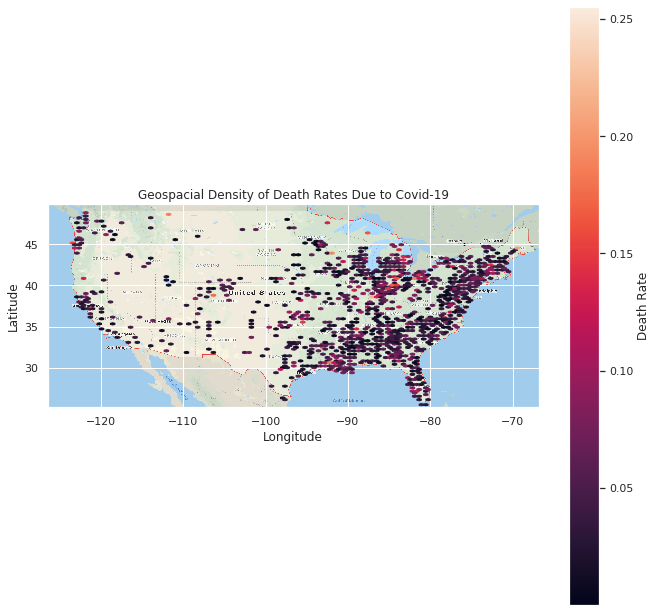

In [5]:
min_lon = comp_table2['lon'].min()
max_lon = comp_table2['lon'].max()
min_lat = comp_table2['lat'].min()
max_lat = comp_table2['lat'].max()
max_death = comp_table2['death rate'].max()
min_death = comp_table2['death rate'].min()
bound = ((min_lon, max_lon, min_lat, max_lat))
min_lon, max_lon, min_lat, max_lat
map_bound = ((-126.4157092, -66.86232382, 25.23393405, 49.82053446))

# Read in the base map and setting up subplot
basemap = plt.imread('./usa.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])


# Create the hexbin plot
plt.hexbin(x = comp_table2['lon'], y = comp_table2['lat'], C = comp_table2['death rate'], gridsize = 100) 
plt.colorbar().set_label("Death Rate")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospacial Density of Death Rates Due to Covid-19")

# Setting aspect ratio and plotting the hexbins on top of the base map layer
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');

We noticed from this heatmap that most death rates of counties are close to 0.05 or lower, as a majority of the dots (representing individual counties) are black or dark purple. We also noticed a considerable number of dots that are lighter purple (representing death rate close to 0.1), a few dots that are red (representing death rate close to 0.15), and very few that are orange or yellow (representing death rate close to 0.2). We noticed that counties near Michigan, Indiana, Ohio, and Louisiana have a noticeably dense cluster of lighter-colored dots, which represent higher death rates.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Relationship between the Death Rate and the Social Vulnerability Index Percentile in Counties in USA')

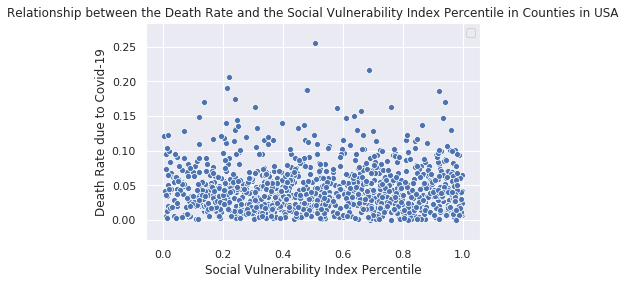

In [6]:
ax = sns.scatterplot(x=comp_table2['SVIPercentile'],
                     y=comp_table2['death rate'])

ax.legend()
plt.ylabel('Death Rate due to Covid-19')
plt.xlabel('Social Vulnerability Index Percentile')
plt.title('Relationship between the Death Rate and the Social Vulnerability Index Percentile in Counties in USA')

We did not notice a clear trend between the SVI (Social Vulnerability Index) Percentile and death rate by COVID-19 in each county. This was surprising because we had expected to see a positive correlation between the two variables as we thought that counties with greater social vulnerability would have higher death rates. 

(0, 1750)

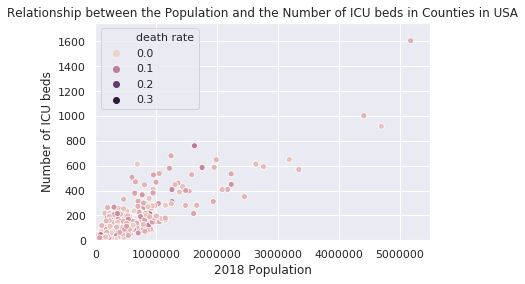

In [7]:
ax = sns.scatterplot(x=comp_table2['PopulationEstimate2018'], 
                 y=comp_table2['#ICU_beds'],
                 hue = comp_table2['death rate'])

ax.legend()
plt.xlabel('2018 Population')
plt.ylabel('Number of ICU beds')
plt.title('Relationship between the Population and the Number of ICU beds in Counties in USA')
plt.xlim(0, 5500000)
plt.ylim(0, 1750)

We noticed a positive correlation between the population and the number of ICU beds in each county. This was consistent with our expectation that higher numbers of ICU beds would be supplied in counties with larger populations. We also decided to look at death rate as a variable by adding it as the hue of each dot. However, we did not recognize a particular pattern with death rate. All we noticed was that most of the counties on the plot have death rates close to 0 for now and a few have death rates close to 0.1. 

As we thought that the availability of ICU beds would be a good feature for predicting the death rate, we decided to add it as one of our features. Because the standard for how many ICU beds a county has depends on its population, we decided to divide the '#ICU_beds' column by the 'PopulationEstimate2018' column and add the results in a new column called 'ICU beds per population' in our dataframe. 

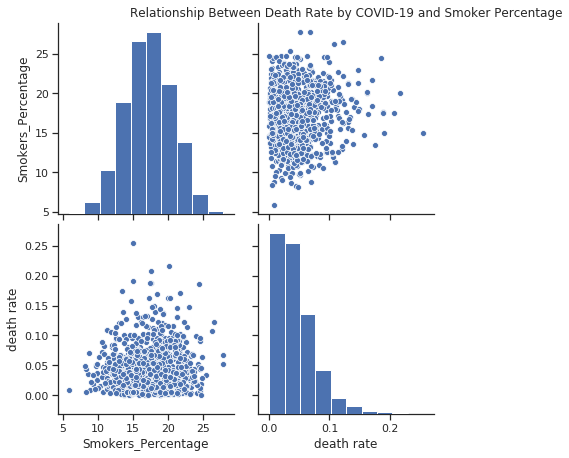

In [8]:
# Pair Plot Comparison of Smoker Percentage and Death Rate
sns.set(style="ticks", color_codes=True)
pp = sns.pairplot(data=comp_table2[["Smokers_Percentage", "death rate"]], height= 3)

plt.title("Relationship Between Death Rate by COVID-19 and Smoker Percentage")
plt.show()

We noticed from this pair plot that death rate increases towards the 15 to 20 range of smokers percentage. This was somewhat surprising because we expected a positive correlation between death rate and smokers percentage as we thought that smoking would affect whether or not a person survives COVID-19. Yet this pair plot did not show a clear positive correlation between these two variables.

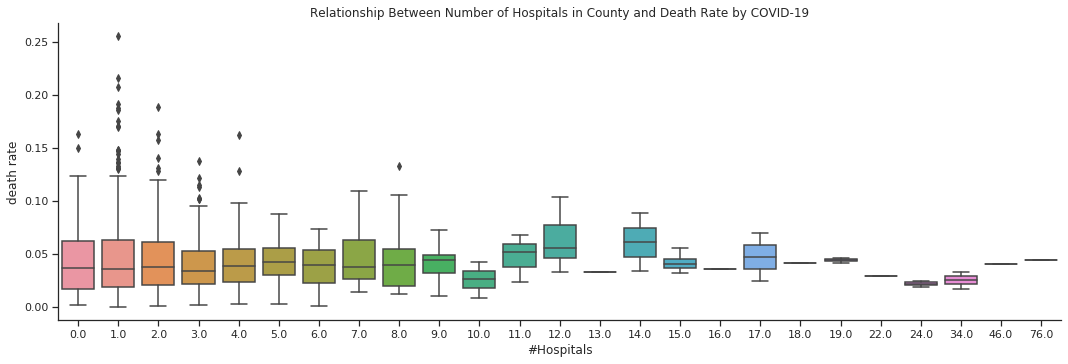

In [9]:
# Relationship beween Number of Hospitals in Counties and Death Rate by COVID-19

sns.catplot(x="#Hospitals", y="death rate", kind="box", data=comp_table2, aspect = 3);
plt.title("Relationship Between Number of Hospitals in County and Death Rate by COVID-19")
plt.show()

This box and whisker plot clearly shows that smaller numbers of hospitals have larger interquartile ranges of death rates. Yet, it does not show a particular trend between the median death rate and the number of hospitals. This is most likely because the number of hospitals does not necessarily indicate better health care opportunities; we should be considering the population of each county as well, as it makes sense for a county with a smaller population to have a smaller number of hospitals. We therefore decided that Medicare Percentage would be a better indicator of the level of healthcare than the number of hospitals. Thus, we ended up adding Medicare Percentage as one of our features by dividing the 'MedicareEnrollment,AgedTot2017' column by the 'PopulationEstimate2018' column.

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


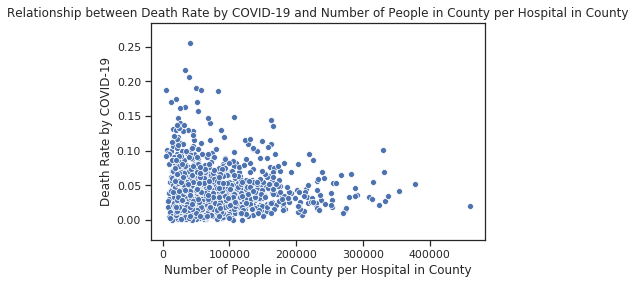

In [10]:
# Relationship beween Number of Hospitals by Population in Counties and Death Rate by COVID-19

temp_table = comp_table[["#Hospitals", "death rate", "PopulationEstimate2018"]]
temp_table["People per Hospital"] = temp_table["PopulationEstimate2018"]/temp_table["#Hospitals"]

ax = sns.scatterplot(x=temp_table['People per Hospital'], 
                 y=temp_table['death rate'],
                 x_jitter=0.5, y_jitter=0.5)

plt.xlabel('Number of People in County per Hospital in County')
plt.ylabel('Death Rate by COVID-19')
plt.title('Relationship between Death Rate by COVID-19 and Number of People in County per Hospital in County')
plt.show()

We added a new column called 'People per Hospital' to look at the relationship between the number of people per hospital and the death rate due to COVID-19 in each county. We noticed from the plot above that there isn't a clear correlation between these two variables. This was contrary to our expectation that a higher number of people per hospital would lead to lower death rate. We therefore concluded that the number of people per hospital is not a good indicator of death rate and decided not to include it in our feature set.

## Data Modelling & Feature Engineering

In [11]:
# Using sklearn.model_selection to split data randomly into train and test sets

from sklearn.model_selection import train_test_split

train, test = train_test_split(comp_table2, test_size=0.1, random_state=42)

# Standardize data and finish data cleaning process

def normalize(data):
    '''
    Args:
        data : a dataframe
    Returns:
        the normalized version of input data with NAN values filled with 0's
    '''
    stand_data = (data - np.mean(data)) / np.std(data)
    stand_data = stand_data.fillna(0)
    return stand_data

Y_Train = train['death rate']
Y_Test = test['death rate']

X_Train = train.iloc[:, 8:]
X_Test = test.iloc[:, 8:]

X_Train = X_Train.apply(pd.to_numeric) 
X_Test = X_Test.apply(pd.to_numeric)

x_train_norm = normalize(X_Train)
test_norm = normalize(X_Test)

# Select 5 best features for regression based on SelectKBest module

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=5)
five_selected = fs.fit_transform(x_train_norm, Y_Train)

# Resulting 5 best features are: MedianAge2010, HeartDiseaseMortality, elderly ratio, stay at home, and Medicare Percentage

x_train_norm1 = x_train_norm[["elderly ratio", "Medicare Percentage", "MedianAge2010", "HeartDiseaseMortality", "stay at home"]]
test_norm1 = test_norm[["elderly ratio", "Medicare Percentage", "MedianAge2010", "HeartDiseaseMortality", "stay at home"]]

/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/srv/conda/envs/data100/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/srv/conda/envs/data100/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/srv/conda/envs/data100/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


We split our final dataframe into X_Train, Y_train, X_Test, and Y_Test dataframes and normalized the values in X_Train and X_Test. 

We then began creating our linear model by using the SelectKBest module from sklearn.feature_selection to select the five best features from x_train_norm for predicting Y_Train (death rate). The resulting five best features were MedianAge2010, HeartDiseaseMortality, elderly ratio, stay at home, and Medicare Percentage. These five features made up our initial feature set. We selected only these five columns from x_train_norm and test_norm then assigned these new dataframes to x_train_norm1 and test_norm1, respectively.

In [12]:
# Create Linear Regression Model based on the 5 best features and find Rsquared and training & test RMSE

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train_norm1, Y_Train)

training_accuracy = model.score(x_train_norm1, Y_Train)
print("R_squared: ", training_accuracy)

def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groudtruth
    """
    return np.sqrt(np.mean((actual_y - predicted_y) ** 2))

Y_pred = model.predict(test_norm1)

train_error = rmse(Y_Train, model.predict(x_train_norm1))
test_error = rmse(Y_Test, Y_pred)
print("Training RMSE:", train_error)
print("Test RMSE:", test_error)

R_squared:  0.09121600084774684
Training RMSE: 0.03192655661290187
Test RMSE: 0.03260828726921864


We imported the LinearRegression module from sklearn.linear_model and used it to fit our x_train_norm1 (dataframe with the initial five features selected) and Y_Train (death rate) values. We calculated the training accuracy using model.score and used the rmse function and model.predict to calculate the Training RMSE and the Test RMSE. 

The training accuracy of x_train_norm1 was around 0.091216. Although the training RMSE (around 0.031926) and the test RMSE (around 0.0326082) were low, the training accuracy was a lot lower than we expected and we decided to change our set of features to increase the training accuracy of our model. 

In [13]:
# This time select 10 best features based on SelectKBest module

ts = SelectKBest(score_func=f_regression, k=10)
ten_selected = fs.fit_transform(x_train_norm, Y_Train)

# Resulting 10 best features are: Rural-UrbanContinuumCode2013, MedianAge2010, HeartDiseaseMortality, 
# stayathome, publicschools, restaurantdinein, HPSAShortage, HPSAUnderservedPop, elderly ratio, and Medicare Percentage

x_train_norm2 = x_train_norm[["HPSAShortage", "elderly ratio", "Medicare Percentage", "HeartDiseaseMortality", "stay at home", "MedianAge2010", "Rural-UrbanContinuumCode2013", "public schools", "restaurant dine-in", "HPSAUnderservedPop"]]
test_norm2 = test_norm[["HPSAShortage", "elderly ratio", "Medicare Percentage", "HeartDiseaseMortality", "stay at home", "MedianAge2010", "Rural-UrbanContinuumCode2013", "public schools", "restaurant dine-in", "HPSAUnderservedPop"]]

/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/srv/conda/envs/data100/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/srv/conda/envs/data100/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/srv/conda/envs/data100/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


To create a linear model with higher training accuracy, we tried adding more features to our feature set. We used SelectKBest again, this time selecting the ten best features for regression. The resulting ten best features were Rural-UrbanContinuumCode2013, MedianAge2010, HeartDiseaseMortality, #stayathome, publicschools, restaurantdinein, HPSAShortage, HPSAUnderservedPop, elderly ratio, and Medicare Percentage. This new set was equivalent to the addition of Rural-UrbanContinuumCode2013, publicschools, restaurantdinein, HPSAShortage, and HPSAUnderservedPop to our inital set of five features.

This time, we selected these ten columns from x_train_norm and test_norm then assigned these new dataframes to x_train_norm2 and test_norm2, respectively.

In [14]:
# Create Linear Regression Model based on the 10 best features and find Rsquared and training & test RMSE

model = LinearRegression().fit(x_train_norm2, Y_Train)

training_accuracy2 = model.score(x_train_norm2, Y_Train)

print("R_squared: ", training_accuracy2)

Y_pred = model.predict(test_norm2)

train_error2 = rmse(Y_Train, model.predict(x_train_norm2))
test_error2 = rmse(Y_Test, Y_pred)
print("Training RMSE:", train_error2)
print("Test RMSE:", test_error2)

R_squared:  0.0976654830621363
Training RMSE: 0.031813066285281785
Test RMSE: 0.0327388065015713


Again, we used the LinearRegression module from sklearn.linear_model to fit our x_train_norm2 (10 best features) and Y_Train (death rate) values. We calculated the training accuracy using model.score and used the rmse function and model.predict to calculate Training RMSE and Test RMSE.

The training accuracy of the x_train_norm2 values was around 0.097665. Although this was only slightly higher than our inital training accuracy (0.091216), it was still an improvement. Additionally, the training RMSE decreased from around 0.031926 to 0.031813 yet the test RMSE increased from around 0.0326082 to 0.0327388. Although these changes were very subtle, we decided to look into the number of features used in our feature set and find out which number of features resulted in the smallest cross validation RMSE.

In [15]:
# Find cross-validation rmse for 10 best linear regression model

from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

cv_error = cross_validate_rmse(model, x_train_norm2, Y_Train)
print("Cross Validation RMSE: {}".format(cv_error))

Cross Validation RMSE: 0.03219428683578619


The cross validation RMSE for our linear regression model with the ten best features was about 0.0321943. We decided to see if selecting a smaller number of these features would result in a lower cross validation RMSE. 

Text(0.5, 1.0, 'Cross Validation RMSE for Number of Features Used in Training Set')

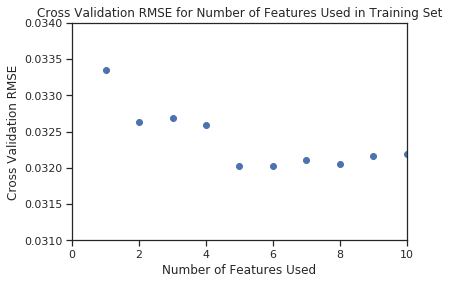

In [16]:
cv_errors = []
num_features_array = []

for n in range(1, 11):
    
    num_features_array.append(n)
    
    # compute the cross validation error
    cv_error = cross_validate_rmse(model, x_train_norm2.iloc[:, :n], Y_Train)
    cv_errors.append(cv_error)
    
plt.scatter(x = num_features_array, y= cv_errors)
plt.xlim(0, 10)
plt.ylim(0.031, 0.034)
plt.xlabel('Number of Features Used')
plt.ylabel('Cross Validation RMSE')
plt.title('Cross Validation RMSE for Number of Features Used in Training Set')

We created a for loop and a scatter plot to show the cross validation RMSE for each number of features used (1 to 10) from the 10 best features set.

The scatter plot shows that from 0 features to 5 features, there is a somewhat decreasing trend between cross validation RMSE and the number of features used. However from 5 to 10 features, there is a very subtle increasing trend between cross validation RMSE and the number of features used. We concluded from the plot that using five features in our linear regression model results in the lowest cross validation RMSE. 

tensorflow 2.0.0 has requirement tensorboard<2.1.0,>=2.0.0, but you have tensorboard 2.1.0.
okpy 1.13.11 has requirement requests==2.12.4, but you have requests 2.22.0.
